In [1]:
import sys
import torch
import numpy as np
from PIL import Image
import coremltools as ct
import matplotlib.pyplot as plt
from torchvision import transforms
from segment_anything import sam_model_registry, SamPredictor

sys.path.append("..")

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [2]:
input_image = Image.open("cat_dog.jpg")
input_image = np.array(input_image)

In [3]:
from segment_anything import sam_model_registry, SamPredictor

predictor = SamPredictor(sam)
predictor.set_image(input_image)

input_point = np.array([[500, 375]])
input_label = np.array([1])

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [4]:
print(masks.shape)
print(scores.shape)
print(logits.shape)

(3, 448, 448)
(3,)
(3, 256, 256)


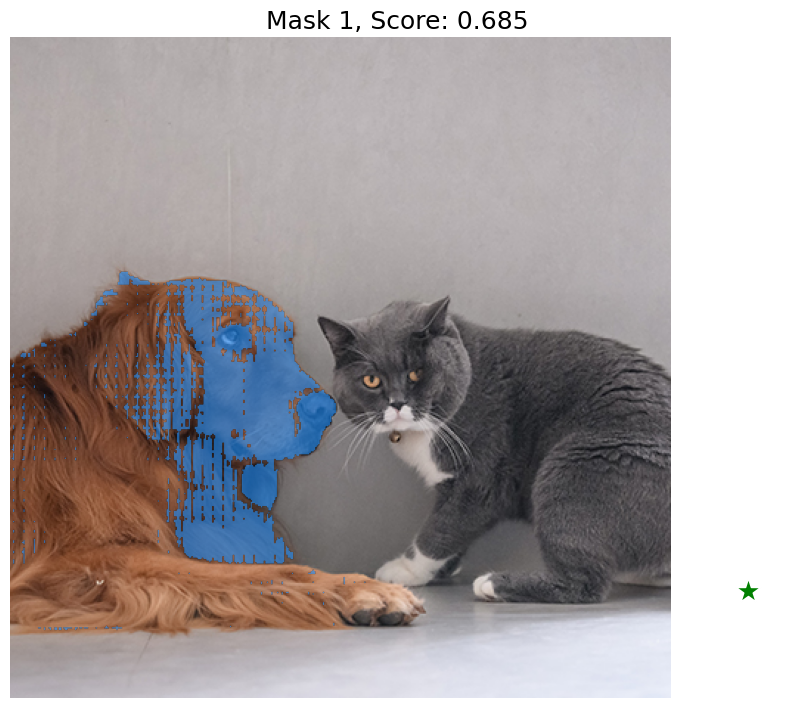

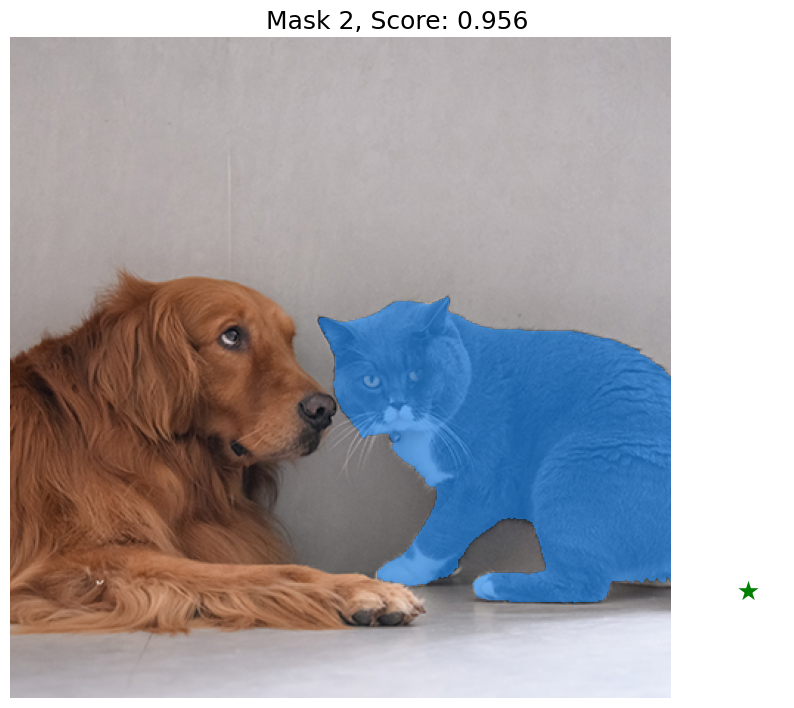

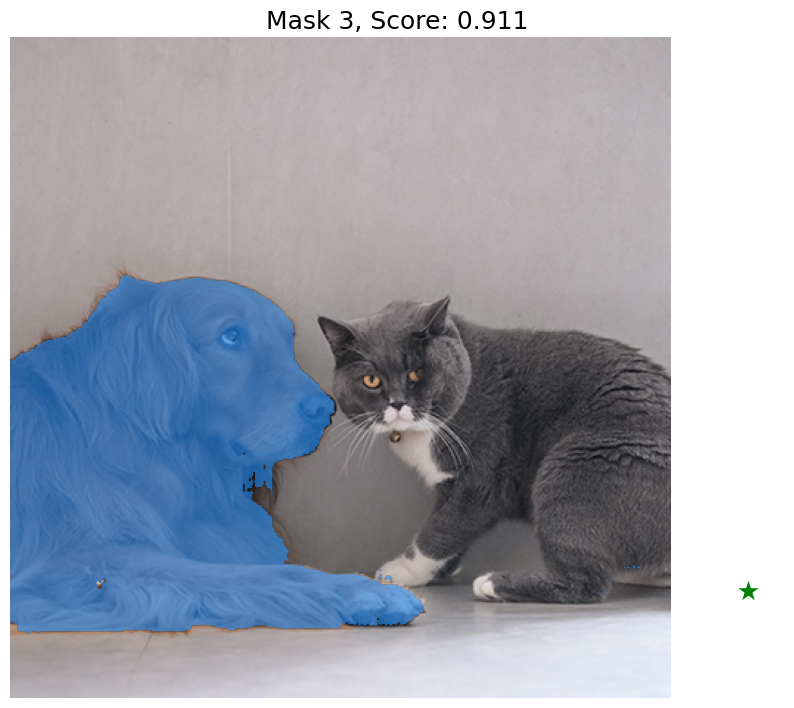

In [5]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(input_image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()    

In [7]:
class WrappedSAM(torch.nn.Module):
    def __init__(self):
        super(WrappedSAM, self).__init__()
        sam_checkpoint = "sam_vit_h_4b8939.pth"
        model_type = "vit_h"
        self.model = sam_model_registry[model_type](checkpoint=sam_checkpoint).eval()

    def forward(self, x):
        # set multimask_output=True
        res = self.model(x, multimask_output=True)
        return res[0]

traceable_model = WrappedSAM().eval()
trace = torch.jit.trace(traceable_model, input_batch)        

RuntimeError: Tracer cannot infer type of (array([[169, 163, 163],
       [170, 164, 164],
       [170, 164, 164],
       ...,
       [178, 173, 177],
       [176, 171, 175],
       [175, 170, 174]], dtype=uint8), array([[168, 162, 162],
       [169, 163, 163],
       [172, 166, 166],
       ...,
       [176, 171, 175],
       [176, 172, 173],
       [177, 173, 174]], dtype=uint8), array([[171, 165, 165],
       [168, 162, 162],
       [171, 165, 165],
       ...,
       [174, 170, 171],
       [175, 171, 172],
       [177, 173, 174]], dtype=uint8), array([[171, 165, 165],
       [168, 162, 162],
       [169, 163, 163],
       ...,
       [175, 171, 172],
       [176, 172, 173],
       [176, 172, 173]], dtype=uint8), array([[170, 164, 164],
       [172, 166, 166],
       [171, 165, 165],
       ...,
       [175, 171, 170],
       [176, 172, 173],
       [176, 172, 173]], dtype=uint8), array([[168, 162, 162],
       [173, 167, 167],
       [173, 167, 167],
       ...,
       [176, 170, 170],
       [174, 168, 170],
       [178, 172, 176]], dtype=uint8), array([[171, 165, 165],
       [173, 167, 167],
       [172, 166, 166],
       ...,
       [178, 172, 172],
       [174, 168, 170],
       [176, 170, 174]], dtype=uint8), array([[171, 165, 165],
       [172, 166, 166],
       [173, 167, 167],
       ...,
       [178, 172, 172],
       [177, 171, 173],
       [177, 171, 175]], dtype=uint8), array([[171, 165, 165],
       [171, 165, 165],
       [173, 167, 167],
       ...,
       [177, 171, 173],
       [180, 174, 176],
       [179, 173, 175]], dtype=uint8), array([[170, 164, 164],
       [172, 166, 166],
       [173, 167, 167],
       ...,
       [173, 167, 169],
       [179, 173, 175],
       [182, 176, 178]], dtype=uint8), array([[171, 165, 165],
       [171, 165, 165],
       [171, 165, 165],
       ...,
       [175, 169, 171],
       [178, 172, 174],
       [179, 173, 175]], dtype=uint8), array([[171, 167, 166],
       [171, 165, 165],
       [172, 166, 166],
       ...,
       [178, 172, 176],
       [177, 171, 175],
       [178, 172, 174]], dtype=uint8), array([[170, 164, 164],
       [172, 166, 166],
       [172, 166, 166],
       ...,
       [179, 173, 177],
       [177, 171, 175],
       [179, 173, 177]], dtype=uint8), array([[170, 164, 164],
       [173, 167, 167],
       [173, 164, 165],
       ...,
       [179, 173, 177],
       [179, 173, 177],
       [178, 172, 176]], dtype=uint8), array([[169, 163, 163],
       [174, 165, 166],
       [173, 164, 165],
       ...,
       [177, 171, 175],
       [178, 172, 176],
       [178, 172, 176]], dtype=uint8), array([[171, 162, 163],
       [173, 164, 165],
       [177, 168, 169],
       ...,
       [178, 172, 176],
       [177, 171, 175],
       [177, 171, 175]], dtype=uint8), array([[174, 164, 165],
       [175, 165, 166],
       [176, 166, 167],
       ...,
       [181, 176, 180],
       [178, 173, 177],
       [175, 170, 174]], dtype=uint8), array([[173, 163, 164],
       [174, 164, 165],
       [174, 164, 165],
       ...,
       [177, 172, 176],
       [177, 172, 176],
       [176, 171, 175]], dtype=uint8), array([[173, 163, 164],
       [173, 164, 165],
       [171, 162, 163],
       ...,
       [175, 170, 174],
       [174, 169, 173],
       [177, 172, 176]], dtype=uint8), array([[175, 166, 167],
       [174, 165, 166],
       [172, 164, 162],
       ...,
       [177, 172, 176],
       [177, 172, 176],
       [175, 170, 174]], dtype=uint8), array([[173, 164, 165],
       [174, 166, 164],
       [175, 167, 165],
       ...,
       [178, 173, 177],
       [178, 173, 177],
       [176, 171, 175]], dtype=uint8), array([[176, 168, 166],
       [176, 168, 166],
       [177, 169, 167],
       ...,
       [176, 171, 175],
       [176, 171, 175],
       [179, 174, 178]], dtype=uint8), array([[180, 172, 170],
       [176, 168, 166],
       [175, 167, 165],
       ...,
       [176, 171, 175],
       [178, 173, 177],
       [179, 174, 178]], dtype=uint8), array([[174, 169, 166],
       [172, 167, 164],
       [175, 167, 165],
       ...,
       [178, 173, 177],
       [178, 173, 177],
       [178, 173, 177]], dtype=uint8), array([[172, 167, 164],
       [174, 169, 166],
       [176, 168, 165],
       ...,
       [180, 175, 179],
       [181, 176, 180],
       [179, 174, 178]], dtype=uint8), array([[174, 168, 168],
       [175, 170, 167],
       [175, 170, 166],
       ...,
       [178, 173, 177],
       [180, 175, 179],
       [179, 174, 178]], dtype=uint8), array([[174, 169, 166],
       [174, 169, 166],
       [174, 169, 165],
       ...,
       [179, 174, 178],
       [180, 175, 179],
       [181, 176, 180]], dtype=uint8), array([[172, 167, 164],
       [172, 167, 164],
       [173, 168, 164],
       ...,
       [180, 174, 176],
       [180, 174, 178],
       [182, 176, 180]], dtype=uint8), array([[171, 166, 163],
       [171, 166, 163],
       [174, 166, 164],
       ...,
       [182, 176, 178],
       [181, 175, 177],
       [182, 176, 180]], dtype=uint8), array([[175, 167, 165],
       [174, 166, 164],
       [174, 166, 164],
       ...,
       [182, 176, 178],
       [181, 175, 177],
       [180, 174, 176]], dtype=uint8), array([[174, 169, 166],
       [175, 167, 165],
       [174, 166, 164],
       ...,
       [181, 175, 177],
       [183, 177, 179],
       [181, 175, 177]], dtype=uint8), array([[174, 169, 165],
       [174, 169, 166],
       [176, 168, 166],
       ...,
       [181, 175, 177],
       [183, 177, 179],
       [182, 176, 178]], dtype=uint8), array([[176, 167, 168],
       [178, 169, 170],
       [177, 168, 169],
       ...,
       [180, 174, 176],
       [182, 176, 178],
       [181, 175, 177]], dtype=uint8), array([[175, 169, 169],
       [174, 168, 168],
       [177, 168, 169],
       ...,
       [177, 171, 173],
       [181, 175, 177],
       [181, 175, 177]], dtype=uint8), array([[172, 167, 164],
       [174, 168, 168],
       [177, 168, 169],
       ...,
       [182, 176, 178],
       [181, 175, 177],
       [180, 174, 176]], dtype=uint8), array([[172, 166, 166],
       [176, 167, 168],
       [176, 167, 168],
       ...,
       [180, 174, 176],
       [180, 174, 176],
       [181, 175, 177]], dtype=uint8), array([[173, 167, 167],
       [174, 168, 168],
       [177, 168, 169],
       ...,
       [181, 175, 177],
       [178, 172, 174],
       [179, 173, 175]], dtype=uint8), array([[175, 169, 171],
       [174, 168, 170],
       [175, 169, 169],
       ...,
       [180, 174, 176],
       [179, 173, 175],
       [181, 175, 175]], dtype=uint8), array([[177, 171, 171],
       [177, 171, 171],
       [175, 169, 169],
       ...,
       [176, 170, 174],
       [180, 174, 176],
       [180, 174, 176]], dtype=uint8), array([[178, 172, 172],
       [179, 173, 173],
       [175, 169, 169],
       ...,
       [178, 172, 176],
       [175, 169, 173],
       [177, 171, 175]], dtype=uint8), array([[176, 170, 170],
       [176, 170, 170],
       [176, 170, 170],
       ...,
       [179, 173, 177],
       [179, 173, 175],
       [179, 173, 175]], dtype=uint8), array([[175, 166, 167],
       [176, 167, 168],
       [176, 170, 170],
       ...,
       [184, 178, 182],
       [185, 179, 181],
       [186, 180, 182]], dtype=uint8), array([[176, 167, 168],
       [175, 167, 165],
       [178, 170, 168],
       ...,
       [184, 178, 182],
       [185, 179, 183],
       [185, 179, 183]], dtype=uint8), array([[180, 172, 170],
       [176, 171, 168],
       [176, 171, 168],
       ...,
       [182, 176, 180],
       [184, 179, 183],
       [182, 177, 181]], dtype=uint8), array([[177, 172, 169],
       [177, 172, 169],
       [174, 169, 166],
       ...,
       [184, 178, 182],
       [186, 181, 185],
       [183, 178, 182]], dtype=uint8), array([[176, 168, 166],
       [177, 169, 167],
       [172, 167, 163],
       ...,
       [184, 179, 183],
       [184, 179, 183],
       [183, 178, 182]], dtype=uint8), array([[177, 169, 167],
       [177, 169, 167],
       [177, 169, 167],
       ...,
       [182, 177, 181],
       [182, 177, 181],
       [184, 179, 183]], dtype=uint8), array([[178, 170, 168],
       [179, 171, 169],
       [179, 174, 171],
       ...,
       [183, 178, 182],
       [184, 179, 183],
       [185, 180, 184]], dtype=uint8), array([[177, 169, 167],
       [178, 170, 167],
       [176, 171, 167],
       ...,
       [184, 179, 183],
       [182, 177, 181],
       [184, 179, 183]], dtype=uint8), array([[180, 172, 170],
       [178, 170, 168],
       [175, 170, 166],
       ...,
       [185, 180, 184],
       [184, 179, 183],
       [183, 178, 182]], dtype=uint8), array([[177, 169, 167],
       [176, 168, 166],
       [177, 172, 169],
       ...,
       [186, 181, 185],
       [184, 179, 183],
       [184, 179, 183]], dtype=uint8), array([[175, 167, 165],
       [177, 169, 167],
       [177, 172, 169],
       ...,
       [184, 179, 183],
       [185, 180, 184],
       [184, 179, 183]], dtype=uint8), array([[178, 170, 168],
       [179, 171, 169],
       [176, 171, 168],
       ...,
       [184, 179, 183],
       [186, 181, 185],
       [184, 179, 183]], dtype=uint8), array([[181, 173, 171],
       [180, 172, 170],
       [180, 172, 170],
       ...,
       [184, 179, 183],
       [184, 179, 183],
       [185, 180, 184]], dtype=uint8), array([[180, 172, 169],
       [180, 172, 169],
       [182, 174, 171],
       ...,
       [183, 178, 182],
       [183, 178, 182],
       [184, 179, 183]], dtype=uint8), array([[179, 171, 168],
       [181, 173, 170],
       [180, 172, 169],
       ...,
       [185, 180, 184],
       [186, 181, 185],
       [184, 179, 183]], dtype=uint8), array([[179, 171, 169],
       [179, 171, 169],
       [180, 172, 170],
       ...,
       [188, 183, 187],
       [186, 181, 185],
       [184, 179, 183]], dtype=uint8), array([[180, 172, 170],
       [179, 171, 169],
       [180, 172, 170],
       ...,
       [186, 181, 185],
       [185, 180, 184],
       [183, 178, 182]], dtype=uint8), array([[179, 171, 169],
       [182, 174, 172],
       [184, 176, 174],
       ...,
       [181, 176, 180],
       [183, 178, 182],
       [186, 181, 185]], dtype=uint8), array([[181, 173, 171],
       [179, 171, 169],
       [180, 172, 170],
       ...,
       [182, 177, 181],
       [185, 180, 184],
       [186, 181, 185]], dtype=uint8), array([[179, 171, 169],
       [181, 173, 171],
       [184, 176, 174],
       ...,
       [185, 180, 184],
       [186, 181, 185],
       [184, 179, 183]], dtype=uint8), array([[177, 169, 167],
       [180, 172, 170],
       [183, 175, 173],
       ...,
       [186, 181, 185],
       [183, 178, 182],
       [181, 176, 180]], dtype=uint8), array([[178, 170, 168],
       [180, 172, 170],
       [182, 174, 172],
       ...,
       [183, 178, 182],
       [182, 177, 181],
       [182, 177, 181]], dtype=uint8), array([[181, 173, 171],
       [178, 170, 168],
       [179, 171, 169],
       ...,
       [182, 177, 181],
       [184, 179, 183],
       [183, 178, 182]], dtype=uint8), array([[182, 174, 172],
       [179, 171, 169],
       [178, 170, 168],
       ...,
       [180, 176, 177],
       [182, 176, 180],
       [183, 177, 181]], dtype=uint8), array([[180, 172, 170],
       [179, 171, 169],
       [177, 169, 167],
       ...,
       [182, 178, 179],
       [184, 178, 182],
       [184, 178, 182]], dtype=uint8), array([[178, 170, 168],
       [179, 171, 169],
       [177, 169, 167],
       ...,
       [184, 180, 181],
       [184, 180, 181],
       [184, 179, 183]], dtype=uint8), array([[178, 170, 168],
       [181, 173, 171],
       [180, 172, 170],
       ...,
       [187, 183, 184],
       [185, 181, 182],
       [184, 180, 181]], dtype=uint8), array([[177, 169, 167],
       [178, 170, 168],
       [182, 174, 172],
       ...,
       [185, 181, 182],
       [186, 182, 183],
       [186, 182, 183]], dtype=uint8), array([[178, 170, 168],
       [178, 170, 168],
       [179, 171, 169],
       ...,
       [184, 180, 181],
       [186, 182, 183],
       [186, 182, 183]], dtype=uint8), array([[179, 171, 169],
       [179, 171, 169],
       [178, 170, 168],
       ...,
       [186, 182, 183],
       [186, 182, 183],
       [185, 181, 182]], dtype=uint8), array([[178, 170, 168],
       [180, 172, 170],
       [180, 172, 170],
       ...,
       [186, 182, 183],
       [185, 181, 182],
       [184, 182, 183]], dtype=uint8), array([[179, 171, 169],
       [179, 171, 169],
       [181, 173, 171],
       ...,
       [185, 180, 186],
       [187, 182, 186],
       [185, 184, 182]], dtype=uint8), array([[180, 172, 170],
       [179, 171, 169],
       [178, 170, 168],
       ...,
       [187, 180, 187],
       [186, 181, 185],
       [185, 181, 180]], dtype=uint8), array([[178, 170, 168],
       [179, 171, 169],
       [178, 170, 168],
       ...,
       [184, 179, 183],
       [185, 180, 184],
       [184, 180, 181]], dtype=uint8), array([[178, 170, 168],
       [179, 171, 169],
       [180, 172, 170],
       ...,
       [185, 180, 184],
       [186, 181, 185],
       [186, 182, 183]], dtype=uint8), array([[178, 170, 168],
       [179, 171, 169],
       [180, 172, 170],
       ...,
       [187, 182, 186],
       [186, 181, 185],
       [185, 181, 182]], dtype=uint8), array([[180, 172, 170],
       [180, 172, 170],
       [180, 172, 170],
       ...,
       [186, 181, 185],
       [186, 181, 185],
       [188, 182, 184]], dtype=uint8), array([[180, 172, 170],
       [181, 173, 171],
       [179, 171, 169],
       ...,
       [186, 181, 185],
       [185, 180, 184],
       [186, 180, 182]], dtype=uint8), array([[179, 171, 169],
       [181, 173, 171],
       [180, 172, 170],
       ...,
       [187, 182, 186],
       [186, 181, 185],
       [185, 181, 182]], dtype=uint8), array([[180, 172, 170],
       [180, 172, 170],
       [179, 171, 169],
       ...,
       [184, 179, 183],
       [186, 182, 183],
       [188, 184, 185]], dtype=uint8), array([[180, 172, 170],
       [179, 171, 169],
       [177, 169, 167],
       ...,
       [186, 181, 185],
       [188, 183, 187],
       [187, 183, 184]], dtype=uint8), array([[176, 168, 166],
       [178, 170, 168],
       [178, 170, 168],
       ...,
       [185, 180, 186],
       [186, 181, 185],
       [188, 182, 186]], dtype=uint8), array([[180, 172, 170],
       [179, 171, 169],
       [179, 171, 169],
       ...,
       [185, 180, 184],
       [184, 178, 182],
       [186, 180, 182]], dtype=uint8), array([[177, 169, 167],
       [178, 170, 168],
       [180, 172, 170],
       ...,
       [185, 180, 184],
       [184, 178, 182],
       [185, 179, 181]], dtype=uint8), array([[177, 169, 167],
       [178, 170, 168],
       [178, 170, 168],
       ...,
       [185, 179, 183],
       [184, 178, 182],
       [185, 179, 181]], dtype=uint8), array([[177, 169, 167],
       [178, 170, 168],
       [178, 170, 168],
       ...,
       [185, 179, 183],
       [185, 179, 183],
       [187, 181, 185]], dtype=uint8), array([[176, 168, 166],
       [178, 170, 168],
       [180, 172, 170],
       ...,
       [188, 181, 188],
       [185, 179, 183],
       [187, 181, 185]], dtype=uint8), array([[179, 171, 169],
       [179, 171, 169],
       [179, 171, 169],
       ...,
       [186, 181, 185],
       [185, 179, 183],
       [188, 182, 186]], dtype=uint8), array([[177, 169, 167],
       [176, 168, 166],
       [179, 171, 169],
       ...,
       [184, 179, 183],
       [186, 181, 185],
       [188, 182, 186]], dtype=uint8), array([[179, 171, 169],
       [179, 171, 169],
       [178, 170, 168],
       ...,
       [186, 181, 185],
       [186, 181, 185],
       [186, 181, 185]], dtype=uint8), array([[179, 171, 169],
       [181, 173, 171],
       [178, 170, 168],
       ...,
       [187, 183, 184],
       [187, 183, 184],
       [187, 183, 184]], dtype=uint8), array([[178, 170, 168],
       [179, 171, 169],
       [179, 171, 169],
       ...,
       [186, 182, 183],
       [187, 183, 184],
       [187, 183, 184]], dtype=uint8), array([[179, 171, 169],
       [179, 171, 169],
       [178, 170, 168],
       ...,
       [185, 181, 182],
       [188, 184, 185],
       [188, 184, 185]], dtype=uint8), array([[178, 170, 168],
       [179, 171, 169],
       [178, 170, 168],
       ...,
       [187, 183, 184],
       [188, 184, 185],
       [188, 184, 185]], dtype=uint8), array([[176, 168, 166],
       [176, 168, 166],
       [180, 172, 170],
       ...,
       [187, 183, 184],
       [188, 184, 185],
       [187, 183, 184]], dtype=uint8), array([[179, 171, 169],
       [177, 169, 167],
       [178, 170, 168],
       ...,
       [187, 181, 183],
       [188, 182, 184],
       [188, 182, 184]], dtype=uint8), array([[179, 171, 169],
       [179, 171, 169],
       [177, 169, 167],
       ...,
       [188, 182, 184],
       [186, 180, 182],
       [190, 184, 186]], dtype=uint8), array([[177, 169, 167],
       [180, 172, 170],
       [180, 172, 170],
       ...,
       [189, 183, 185],
       [188, 182, 184],
       [189, 183, 185]], dtype=uint8), array([[177, 169, 167],
       [178, 170, 168],
       [180, 172, 170],
       ...,
       [188, 182, 184],
       [189, 183, 185],
       [189, 183, 185]], dtype=uint8), array([[178, 170, 168],
       [175, 167, 165],
       [178, 170, 168],
       ...,
       [189, 183, 185],
       [189, 183, 185],
       [189, 183, 185]], dtype=uint8), array([[178, 170, 168],
       [177, 169, 167],
       [179, 171, 169],
       ...,
       [188, 182, 184],
       [189, 183, 185],
       [189, 183, 185]], dtype=uint8), array([[178, 170, 168],
       [180, 172, 170],
       [179, 171, 169],
       ...,
       [184, 178, 180],
       [187, 181, 183],
       [187, 181, 183]], dtype=uint8), array([[180, 172, 170],
       [180, 172, 170],
       [179, 171, 169],
       ...,
       [184, 178, 180],
       [186, 180, 182],
       [184, 178, 180]], dtype=uint8), array([[180, 172, 170],
       [178, 170, 168],
       [179, 171, 169],
       ...,
       [186, 180, 182],
       [184, 178, 180],
       [186, 180, 182]], dtype=uint8), array([[179, 171, 169],
       [178, 170, 168],
       [180, 172, 170],
       ...,
       [185, 179, 181],
       [183, 177, 179],
       [187, 181, 183]], dtype=uint8), array([[178, 170, 168],
       [179, 171, 169],
       [179, 171, 169],
       ...,
       [184, 178, 180],
       [185, 179, 181],
       [188, 182, 184]], dtype=uint8), array([[179, 171, 169],
       [180, 172, 170],
       [178, 170, 168],
       ...,
       [185, 179, 181],
       [188, 182, 184],
       [188, 182, 184]], dtype=uint8), array([[180, 172, 170],
       [179, 171, 169],
       [177, 169, 167],
       ...,
       [185, 179, 181],
       [187, 181, 183],
       [187, 181, 183]], dtype=uint8), array([[177, 169, 167],
       [177, 169, 167],
       [177, 169, 167],
       ...,
       [186, 180, 182],
       [187, 181, 183],
       [186, 180, 182]], dtype=uint8), array([[177, 169, 167],
       [177, 169, 167],
       [178, 170, 168],
       ...,
       [187, 183, 184],
       [186, 182, 183],
       [185, 181, 182]], dtype=uint8), array([[177, 169, 167],
       [178, 170, 168],
       [179, 171, 169],
       ...,
       [187, 183, 184],
       [185, 181, 182],
       [184, 180, 181]], dtype=uint8), array([[177, 169, 167],
       [176, 168, 166],
       [177, 169, 167],
       ...,
       [188, 182, 184],
       [186, 182, 183],
       [186, 182, 183]], dtype=uint8), array([[176, 168, 166],
       [176, 168, 166],
       [179, 171, 169],
       ...,
       [188, 182, 184],
       [189, 183, 185],
       [188, 184, 185]], dtype=uint8), array([[175, 167, 165],
       [176, 168, 166],
       [179, 171, 169],
       ...,
       [187, 181, 183],
       [187, 181, 183],
       [186, 180, 182]], dtype=uint8), array([[177, 169, 167],
       [175, 167, 165],
       [176, 168, 166],
       ...,
       [186, 180, 182],
       [186, 180, 182],
       [188, 182, 184]], dtype=uint8), array([[176, 168, 166],
       [175, 167, 165],
       [177, 169, 167],
       ...,
       [185, 179, 181],
       [187, 181, 183],
       [190, 184, 186]], dtype=uint8), array([[177, 169, 167],
       [176, 168, 166],
       [177, 169, 167],
       ...,
       [184, 178, 180],
       [185, 179, 181],
       [187, 181, 183]], dtype=uint8), array([[177, 169, 167],
       [176, 168, 166],
       [175, 167, 165],
       ...,
       [187, 181, 183],
       [189, 183, 185],
       [187, 183, 184]], dtype=uint8), array([[176, 168, 166],
       [176, 168, 166],
       [174, 166, 164],
       ...,
       [188, 182, 184],
       [188, 184, 185],
       [185, 181, 182]], dtype=uint8), array([[175, 167, 165],
       [175, 167, 165],
       [175, 167, 165],
       ...,
       [186, 180, 182],
       [188, 182, 184],
       [186, 180, 182]], dtype=uint8), array([[175, 167, 165],
       [175, 167, 165],
       [175, 167, 165],
       ...,
       [185, 181, 182],
       [187, 181, 183],
       [188, 182, 184]], dtype=uint8), array([[174, 166, 164],
       [175, 167, 165],
       [177, 169, 167],
       ...,
       [186, 182, 183],
       [184, 180, 181],
       [187, 181, 183]], dtype=uint8), array([[174, 166, 164],
       [175, 167, 165],
       [175, 167, 165],
       ...,
       [186, 182, 183],
       [184, 180, 181],
       [186, 182, 183]], dtype=uint8), array([[177, 169, 167],
       [176, 168, 166],
       [174, 166, 164],
       ...,
       [185, 181, 182],
       [186, 182, 183],
       [186, 182, 183]], dtype=uint8), array([[176, 168, 166],
       [175, 167, 165],
       [174, 166, 164],
       ...,
       [186, 181, 185],
       [187, 183, 184],
       [186, 182, 183]], dtype=uint8), array([[177, 169, 167],
       [177, 169, 167],
       [175, 167, 165],
       ...,
       [187, 182, 186],
       [188, 184, 185],
       [186, 182, 183]], dtype=uint8), array([[177, 169, 167],
       [177, 169, 167],
       [174, 166, 164],
       ...,
       [187, 182, 186],
       [187, 183, 184],
       [187, 183, 184]], dtype=uint8), array([[175, 167, 165],
       [176, 168, 166],
       [174, 166, 164],
       ...,
       [187, 181, 183],
       [186, 182, 183],
       [185, 181, 180]], dtype=uint8), array([[174, 166, 164],
       [171, 163, 161],
       [175, 167, 165],
       ...,
       [185, 179, 181],
       [186, 182, 183],
       [184, 180, 181]], dtype=uint8), array([[173, 165, 162],
       [173, 165, 162],
       [174, 166, 163],
       ...,
       [183, 179, 180],
       [185, 181, 182],
       [185, 181, 182]], dtype=uint8), array([[174, 166, 163],
       [174, 166, 163],
       [174, 166, 163],
       ...,
       [186, 182, 183],
       [185, 181, 182],
       [185, 181, 182]], dtype=uint8), array([[176, 168, 165],
       [173, 165, 162],
       [171, 163, 160],
       ...,
       [184, 180, 181],
       [184, 180, 181],
       [185, 181, 182]], dtype=uint8), array([[178, 170, 167],
       [174, 166, 163],
       [173, 165, 162],
       ...,
       [183, 179, 180],
       [183, 179, 180],
       [184, 180, 181]], dtype=uint8), array([[172, 164, 161],
       [173, 165, 162],
       [172, 164, 161],
       ...,
       [185, 181, 182],
       [186, 182, 183],
       [183, 181, 182]], dtype=uint8), array([[172, 164, 161],
       [169, 161, 158],
       [172, 164, 161],
       ...,
       [186, 182, 183],
       [187, 183, 184],
       [181, 180, 178]], dtype=uint8), array([[171, 166, 162],
       [170, 162, 159],
       [172, 164, 161],
       ...,
       [185, 181, 182],
       [183, 179, 180],
       [184, 180, 181]], dtype=uint8), array([[174, 166, 163],
       [170, 162, 159],
       [170, 162, 159],
       ...,
       [185, 181, 182],
       [185, 181, 182],
       [187, 183, 184]], dtype=uint8), array([[175, 165, 164],
       [171, 161, 160],
       [170, 162, 160],
       ...,
       [183, 179, 180],
       [185, 181, 182],
       [184, 180, 181]], dtype=uint8), array([[173, 163, 162],
       [173, 163, 162],
       [172, 164, 162],
       ...,
       [183, 179, 180],
       [182, 178, 179],
       [185, 181, 182]], dtype=uint8), array([[174, 164, 163],
       [173, 165, 163],
       [174, 166, 164],
       ...,
       [183, 179, 180],
       [181, 177, 178],
       [187, 183, 184]], dtype=uint8), array([[172, 164, 162],
       [172, 164, 162],
       [170, 162, 160],
       ...,
       [183, 179, 180],
       [182, 178, 179],
       [183, 179, 180]], dtype=uint8), array([[172, 164, 162],
       [172, 164, 162],
       [172, 164, 162],
       ...,
       [180, 176, 177],
       [182, 178, 179],
       [184, 180, 181]], dtype=uint8), array([[174, 164, 163],
       [173, 163, 162],
       [171, 161, 160],
       ...,
       [179, 177, 178],
       [183, 179, 180],
       [185, 181, 182]], dtype=uint8), array([[174, 162, 162],
       [174, 164, 163],
       [171, 161, 160],
       ...,
       [185, 181, 182],
       [183, 179, 180],
       [182, 178, 179]], dtype=uint8), array([[173, 163, 162],
       [175, 165, 164],
       [169, 159, 158],
       ...,
       [182, 178, 179],
       [181, 177, 178],
       [181, 177, 178]], dtype=uint8), array([[170, 160, 159],
       [171, 161, 160],
       [172, 162, 161],
       ...,
       [181, 177, 178],
       [180, 176, 177],
       [180, 176, 177]], dtype=uint8), array([[171, 161, 160],
       [169, 159, 158],
       [173, 163, 162],
       ...,
       [183, 179, 180],
       [182, 178, 179],
       [181, 177, 178]], dtype=uint8), array([[170, 160, 159],
       [170, 160, 159],
       [168, 160, 158],
       ...,
       [183, 178, 182],
       [180, 176, 177],
       [181, 177, 178]], dtype=uint8), array([[171, 161, 160],
       [172, 164, 162],
       [170, 162, 160],
       ...,
       [184, 179, 183],
       [184, 179, 183],
       [183, 179, 180]], dtype=uint8), array([[170, 162, 160],
       [171, 163, 161],
       [170, 162, 160],
       ...,
       [184, 179, 183],
       [186, 181, 185],
       [183, 178, 182]], dtype=uint8), array([[170, 162, 160],
       [171, 163, 161],
       [167, 159, 157],
       ...,
       [181, 176, 180],
       [182, 177, 181],
       [184, 179, 183]], dtype=uint8), array([[168, 160, 157],
       [168, 160, 158],
       [167, 159, 157],
       ...,
       [179, 174, 178],
       [182, 176, 180],
       [185, 179, 183]], dtype=uint8), array([[168, 160, 157],
       [167, 159, 157],
       [166, 158, 156],
       ...,
       [184, 179, 183],
       [183, 177, 181],
       [184, 178, 182]], dtype=uint8), array([[168, 158, 157],
       [169, 159, 158],
       [169, 159, 158],
       ...,
       [186, 181, 185],
       [185, 179, 183],
       [183, 177, 181]], dtype=uint8), array([[168, 158, 157],
       [170, 160, 159],
       [168, 158, 157],
       ...,
       [185, 180, 184],
       [186, 180, 184],
       [182, 176, 180]], dtype=uint8), array([[166, 156, 155],
       [166, 156, 155],
       [167, 157, 156],
       ...,
       [184, 179, 183],
       [185, 180, 184],
       [183, 177, 181]], dtype=uint8), array([[165, 155, 154],
       [164, 154, 153],
       [165, 155, 154],
       ...,
       [184, 179, 183],
       [182, 177, 181],
       [182, 177, 181]], dtype=uint8), array([[169, 159, 158],
       [167, 157, 156],
       [165, 155, 154],
       ...,
       [183, 178, 182],
       [181, 176, 180],
       [183, 178, 182]], dtype=uint8), array([[167, 159, 157],
       [167, 157, 156],
       [168, 158, 157],
       ...,
       [182, 177, 181],
       [181, 176, 180],
       [182, 177, 181]], dtype=uint8), array([[164, 156, 154],
       [168, 158, 157],
       [168, 158, 157],
       ...,
       [183, 177, 181],
       [183, 177, 181],
       [182, 176, 180]], dtype=uint8), array([[166, 158, 156],
       [169, 159, 158],
       [168, 158, 157],
       ...,
       [181, 176, 180],
       [183, 177, 181],
       [181, 175, 179]], dtype=uint8), array([[169, 161, 159],
       [166, 158, 156],
       [167, 157, 156],
       ...,
       [181, 176, 180],
       [184, 179, 183],
       [183, 178, 182]], dtype=uint8), array([[167, 159, 157],
       [165, 157, 155],
       [167, 157, 156],
       ...,
       [181, 176, 180],
       [184, 179, 183],
       [185, 180, 184]], dtype=uint8), array([[166, 158, 156],
       [168, 160, 158],
       [168, 158, 157],
       ...,
       [182, 177, 181],
       [181, 176, 180],
       [181, 176, 180]], dtype=uint8), array([[167, 159, 157],
       [166, 158, 156],
       [163, 155, 153],
       ...,
       [181, 176, 180],
       [179, 174, 178],
       [180, 175, 179]], dtype=uint8), array([[166, 158, 156],
       [163, 155, 153],
       [163, 155, 153],
       ...,
       [179, 174, 178],
       [181, 175, 179],
       [184, 178, 182]], dtype=uint8), array([[165, 157, 155],
       [165, 157, 155],
       [167, 159, 157],
       ...,
       [180, 174, 178],
       [181, 175, 179],
       [182, 176, 180]], dtype=uint8), array([[165, 157, 155],
       [163, 155, 153],
       [165, 157, 155],
       ...,
       [180, 176, 177],
       [180, 175, 179],
       [181, 176, 180]], dtype=uint8), array([[163, 155, 153],
       [164, 156, 154],
       [163, 155, 153],
       ...,
       [178, 173, 177],
       [180, 175, 179],
       [182, 177, 183]], dtype=uint8), array([[163, 155, 153],
       [164, 156, 154],
       [168, 158, 157],
       ...,
       [177, 172, 176],
       [180, 175, 179],
       [180, 175, 181]], dtype=uint8), array([[164, 154, 153],
       [165, 155, 154],
       [169, 159, 158],
       ...,
       [177, 173, 174],
       [180, 175, 179],
       [180, 175, 179]], dtype=uint8), array([[165, 155, 154],
       [168, 158, 157],
       [167, 157, 156],
       ...,
       [177, 173, 174],
       [178, 174, 175],
       [179, 175, 176]], dtype=uint8), array([[162, 152, 151],
       [165, 155, 154],
       [166, 156, 155],
       ...,
       [178, 174, 175],
       [179, 175, 176],
       [177, 173, 174]], dtype=uint8), array([[159, 149, 148],
       [160, 150, 149],
       [164, 154, 153],
       ...,
       [178, 174, 175],
       [179, 175, 176],
       [177, 173, 174]], dtype=uint8), array([[163, 153, 152],
       [165, 155, 154],
       [163, 153, 152],
       ...,
       [176, 171, 175],
       [176, 171, 175],
       [177, 172, 176]], dtype=uint8), array([[165, 155, 154],
       [167, 157, 156],
       [165, 155, 154],
       ...,
       [176, 171, 175],
       [175, 170, 174],
       [177, 173, 174]], dtype=uint8), array([[163, 153, 152],
       [166, 156, 155],
       [164, 154, 153],
       ...,
       [177, 172, 176],
       [176, 172, 173],
       [176, 172, 173]], dtype=uint8), array([[163, 153, 151],
       [163, 153, 151],
       [165, 155, 153],
       ...,
       [178, 173, 177],
       [176, 172, 173],
       [177, 173, 174]], dtype=uint8), array([[161, 151, 149],
       [161, 151, 149],
       [163, 153, 151],
       ...,
       [175, 170, 174],
       [176, 171, 175],
       [176, 172, 173]], dtype=uint8), array([[163, 153, 151],
       [161, 151, 149],
       [163, 153, 151],
       ...,
       [172, 167, 171],
       [173, 168, 172],
       [175, 171, 172]], dtype=uint8), array([[165, 155, 153],
       [163, 153, 151],
       [163, 153, 151],
       ...,
       [174, 169, 173],
       [173, 169, 170],
       [177, 173, 174]], dtype=uint8), array([[162, 152, 150],
       [164, 154, 152],
       [161, 151, 149],
       ...,
       [175, 170, 174],
       [176, 172, 173],
       [176, 172, 173]], dtype=uint8), array([[160, 150, 148],
       [162, 152, 150],
       [163, 153, 151],
       ...,
       [174, 169, 173],
       [175, 170, 174],
       [176, 172, 173]], dtype=uint8), array([[160, 150, 148],
       [159, 149, 147],
       [160, 150, 148],
       ...,
       [174, 169, 173],
       [173, 168, 172],
       [174, 169, 173]], dtype=uint8), array([[160, 150, 148],
       [159, 149, 147],
       [162, 152, 150],
       ...,
       [174, 169, 173],
       [172, 167, 171],
       [175, 171, 172]], dtype=uint8), array([[161, 151, 149],
       [158, 148, 146],
       [160, 150, 148],
       ...,
       [173, 168, 172],
       [170, 165, 169],
       [172, 167, 171]], dtype=uint8), array([[159, 149, 147],
       [160, 150, 148],
       [162, 152, 150],
       ...,
       [171, 166, 170],
       [171, 166, 170],
       [171, 166, 170]], dtype=uint8), array([[161, 151, 149],
       [159, 149, 147],
       [159, 149, 147],
       ...,
       [171, 166, 170],
       [172, 167, 171],
       [171, 166, 170]], dtype=uint8), array([[160, 150, 148],
       [158, 148, 146],
       [157, 147, 145],
       ...,
       [169, 164, 168],
       [170, 165, 169],
       [170, 165, 169]], dtype=uint8), array([[156, 146, 144],
       [159, 149, 147],
       [161, 151, 149],
       ...,
       [170, 165, 169],
       [171, 166, 170],
       [171, 166, 170]], dtype=uint8), array([[158, 148, 146],
       [159, 149, 147],
       [160, 150, 148],
       ...,
       [175, 170, 174],
       [177, 172, 176],
       [173, 168, 172]], dtype=uint8), array([[158, 148, 146],
       [157, 147, 145],
       [157, 147, 145],
       ...,
       [173, 169, 170],
       [176, 171, 175],
       [171, 166, 170]], dtype=uint8), array([[156, 146, 144],
       [158, 148, 146],
       [158, 148, 146],
       ...,
       [171, 167, 168],
       [174, 169, 173],
       [172, 167, 171]], dtype=uint8), array([[157, 147, 145],
       [159, 149, 147],
       [157, 147, 145],
       ...,
       [171, 166, 170],
       [171, 166, 170],
       [175, 170, 174]], dtype=uint8), array([[159, 149, 147],
       [158, 148, 146],
       [158, 148, 146],
       ...,
       [172, 167, 171],
       [172, 167, 171],
       [172, 167, 171]], dtype=uint8), array([[155, 145, 143],
       [158, 148, 146],
       [157, 147, 145],
       ...,
       [172, 167, 171],
       [170, 165, 169],
       [171, 166, 170]], dtype=uint8), array([[154, 144, 142],
       [154, 144, 142],
       [156, 146, 144],
       ...,
       [171, 166, 170],
       [170, 165, 169],
       [169, 164, 168]], dtype=uint8), array([[154, 144, 142],
       [154, 144, 142],
       [154, 144, 142],
       ...,
       [173, 168, 172],
       [172, 167, 171],
       [170, 165, 169]], dtype=uint8), array([[154, 144, 142],
       [156, 146, 144],
       [154, 144, 142],
       ...,
       [174, 169, 173],
       [173, 168, 172],
       [171, 166, 170]], dtype=uint8), array([[155, 145, 143],
       [152, 142, 140],
       [153, 142, 140],
       ...,
       [172, 167, 171],
       [168, 163, 167],
       [168, 163, 167]], dtype=uint8), array([[156, 146, 144],
       [151, 141, 139],
       [151, 140, 138],
       ...,
       [170, 165, 169],
       [170, 165, 169],
       [169, 164, 168]], dtype=uint8), array([[152, 142, 140],
       [153, 143, 141],
       [153, 143, 141],
       ...,
       [169, 164, 168],
       [170, 165, 169],
       [172, 167, 171]], dtype=uint8), array([[152, 142, 140],
       [154, 144, 142],
       [152, 142, 140],
       ...,
       [168, 163, 167],
       [170, 165, 169],
       [171, 166, 170]], dtype=uint8), array([[155, 145, 143],
       [153, 143, 141],
       [153, 143, 141],
       ...,
       [168, 163, 167],
       [171, 166, 170],
       [170, 165, 169]], dtype=uint8), array([[155, 145, 143],
       [154, 144, 142],
       [153, 143, 141],
       ...,
       [169, 164, 168],
       [168, 163, 167],
       [169, 164, 168]], dtype=uint8), array([[155, 144, 142],
       [153, 142, 140],
       [153, 143, 141],
       ...,
       [169, 164, 168],
       [166, 161, 165],
       [171, 166, 170]], dtype=uint8), array([[152, 141, 139],
       [152, 141, 139],
       [154, 144, 142],
       ...,
       [167, 162, 166],
       [169, 164, 168],
       [172, 167, 171]], dtype=uint8), array([[152, 142, 141],
       [153, 143, 141],
       [150, 140, 138],
       ...,
       [168, 163, 167],
       [171, 166, 170],
       [173, 168, 172]], dtype=uint8), array([[149, 138, 134],
       [148, 137, 135],
       [155, 144, 142],
       ...,
       [170, 166, 167],
       [172, 167, 171],
       [172, 167, 171]], dtype=uint8), array([[149, 135, 132],
       [149, 138, 134],
       [153, 142, 138],
       ...,
       [169, 165, 166],
       [169, 165, 166],
       [170, 166, 167]], dtype=uint8), array([[150, 139, 137],
       [154, 145, 140],
       [154, 145, 138],
       ...,
       [168, 164, 165],
       [167, 163, 164],
       [168, 164, 165]], dtype=uint8), array([[151, 142, 137],
       [155, 144, 140],
       [154, 143, 141],
       ...,
       [170, 166, 167],
       [170, 166, 167],
       [171, 167, 168]], dtype=uint8), array([[153, 139, 136],
       [153, 138, 135],
       [150, 135, 132],
       ...,
       [173, 169, 170],
       [174, 170, 171],
       [170, 166, 167]], dtype=uint8), array([[152, 138, 137],
       [150, 135, 130],
       [147, 132, 125],
       ...,
       [170, 166, 167],
       [171, 167, 168],
       [168, 163, 167]], dtype=uint8), array([[151, 138, 132],
       [145, 134, 128],
       [142, 131, 125],
       ...,
       [168, 164, 165],
       [166, 161, 165],
       [166, 161, 165]], dtype=uint8), array([[149, 136, 130],
       [143, 129, 126],
       [138, 123, 116],
       ...,
       [166, 162, 163],
       [164, 160, 161],
       [166, 162, 163]], dtype=uint8), array([[140, 116, 106],
       [138, 116, 105],
       [126, 102,  90],
       ...,
       [168, 164, 165],
       [166, 162, 163],
       [166, 162, 163]], dtype=uint8), array([[111,  78,  63],
       [120,  87,  72],
       [123,  90,  73],
       ...,
       [170, 166, 167],
       [168, 164, 165],
       [167, 163, 164]], dtype=uint8), array([[ 86,  49,  31],
       [ 94,  57,  39],
       [119,  82,  64],
       ...,
       [167, 163, 164],
       [169, 165, 166],
       [168, 163, 167]], dtype=uint8), array([[ 79,  43,  27],
       [ 85,  48,  30],
       [ 98,  61,  43],
       ...,
       [169, 165, 166],
       [168, 163, 167],
       [165, 160, 164]], dtype=uint8), array([[ 69,  36,  19],
       [ 75,  39,  23],
       [ 82,  46,  30],
       ...,
       [166, 161, 165],
       [170, 165, 169],
       [167, 162, 166]], dtype=uint8), array([[ 72,  36,  20],
       [ 72,  36,  20],
       [ 73,  36,  20],
       ...,
       [167, 163, 164],
       [167, 162, 166],
       [171, 166, 170]], dtype=uint8), array([[ 73,  36,  20],
       [ 75,  38,  22],
       [ 73,  35,  22],
       ...,
       [167, 163, 164],
       [168, 164, 165],
       [171, 167, 168]], dtype=uint8), array([[ 77,  40,  24],
       [ 75,  38,  22],
       [ 73,  35,  22],
       ...,
       [161, 157, 158],
       [165, 160, 164],
       [165, 160, 164]], dtype=uint8), array([[ 71,  35,  19],
       [ 70,  34,  20],
       [ 69,  31,  18],
       ...,
       [153, 149, 150],
       [161, 157, 158],
       [168, 163, 167]], dtype=uint8), array([[ 62,  29,  14],
       [ 66,  30,  16],
       [ 68,  32,  18],
       ...,
       [160, 156, 157],
       [162, 158, 159],
       [169, 165, 166]], dtype=uint8), array([[ 66,  33,  18],
       [ 72,  36,  22],
       [ 69,  33,  19],
       ...,
       [137, 131, 133],
       [152, 146, 148],
       [161, 157, 158]], dtype=uint8), array([[ 74,  38,  24],
       [ 73,  35,  22],
       [ 74,  36,  23],
       ...,
       [125, 119, 121],
       [149, 143, 145],
       [158, 152, 154]], dtype=uint8), array([[ 78,  41,  25],
       [ 73,  35,  22],
       [ 71,  33,  20],
       ...,
       [117, 113, 114],
       [132, 128, 129],
       [147, 143, 144]], dtype=uint8), array([[ 80,  43,  25],
       [ 73,  36,  20],
       [ 72,  34,  21],
       ...,
       [ 87,  83,  84],
       [101,  97,  98],
       [111, 107, 106]], dtype=uint8), array([[83, 46, 28],
       [75, 38, 22],
       [75, 39, 25],
       ...,
       [59, 55, 54],
       [68, 64, 63],
       [86, 82, 81]], dtype=uint8), array([[77, 38, 21],
       [76, 39, 21],
       [75, 38, 22],
       ...,
       [85, 81, 82],
       [68, 64, 65],
       [68, 64, 63]], dtype=uint8), array([[ 73,  37,  23],
       [ 72,  36,  22],
       [ 71,  35,  21],
       ...,
       [113, 109, 110],
       [ 98,  94,  95],
       [ 88,  84,  85]], dtype=uint8), array([[ 85,  46,  29],
       [ 83,  46,  30],
       [ 81,  45,  29],
       ...,
       [108, 104, 105],
       [100,  96,  97],
       [ 89,  85,  86]], dtype=uint8), array([[ 97,  56,  36],
       [ 88,  49,  32],
       [ 82,  45,  29],
       ...,
       [107, 102, 106],
       [ 99,  94,  98],
       [101,  97,  98]], dtype=uint8), array([[ 91,  50,  32],
       [ 79,  42,  26],
       [ 69,  36,  21],
       ...,
       [120, 115, 119],
       [122, 117, 121],
       [111, 106, 110]], dtype=uint8), array([[ 82,  40,  24],
       [ 73,  36,  20],
       [ 64,  31,  16],
       ...,
       [123, 118, 122],
       [127, 122, 126],
       [113, 108, 112]], dtype=uint8), array([[ 89,  51,  32],
       [ 82,  43,  26],
       [ 82,  43,  26],
       ...,
       [125, 120, 126],
       [129, 124, 130],
       [104,  99, 105]], dtype=uint8), array([[ 96,  55,  37],
       [ 91,  50,  32],
       [ 86,  45,  25],
       ...,
       [120, 115, 121],
       [130, 125, 131],
       [122, 117, 123]], dtype=uint8), array([[ 91,  48,  31],
       [ 88,  49,  32],
       [ 91,  49,  33],
       ...,
       [122, 117, 123],
       [105, 100, 106],
       [109, 104, 110]], dtype=uint8), array([[ 93,  50,  33],
       [ 90,  52,  33],
       [ 92,  50,  34],
       ...,
       [121, 116, 122],
       [112, 107, 113],
       [112, 107, 113]], dtype=uint8), array([[103,  60,  41],
       [ 89,  48,  30],
       [ 87,  46,  28],
       ...,
       [131, 126, 133],
       [118, 113, 119],
       [127, 122, 128]], dtype=uint8), array([[101,  56,  37],
       [ 88,  47,  29],
       [ 82,  41,  23],
       ...,
       [ 95,  92,  99],
       [ 83,  81,  86],
       [ 91,  89,  94]], dtype=uint8), array([[ 98,  53,  32],
       [ 83,  42,  22],
       [ 89,  46,  29],
       ...,
       [ 89,  84,  91],
       [ 99,  94, 100],
       [ 90,  85,  91]], dtype=uint8), array([[107,  62,  41],
       [ 97,  54,  35],
       [ 92,  49,  32],
       ...,
       [127, 122, 129],
       [111, 104, 111],
       [108, 101, 108]], dtype=uint8), array([[112,  65,  45],
       [103,  60,  41],
       [ 92,  49,  30],
       ...,
       [140, 135, 141],
       [112, 107, 113],
       [109, 102, 109]], dtype=uint8), array([[109,  62,  42],
       [101,  58,  39],
       [ 93,  50,  31],
       ...,
       [134, 129, 135],
       [137, 132, 138],
       [116, 111, 117]], dtype=uint8), array([[106,  60,  37],
       [104,  59,  38],
       [ 95,  52,  33],
       ...,
       [ 95,  93,  98],
       [115, 110, 116],
       [120, 115, 121]], dtype=uint8), array([[ 87,  48,  31],
       [ 86,  43,  24],
       [100,  55,  34],
       ...,
       [ 88,  86,  91],
       [110, 105, 111],
       [120, 115, 121]], dtype=uint8), array([[ 53,  19,   7],
       [ 97,  54,  37],
       [116,  68,  46],
       ...,
       [ 89,  84,  90],
       [ 93,  88,  94],
       [122, 117, 123]], dtype=uint8), array([[ 59,  21,   8],
       [114,  67,  47],
       [127,  77,  54],
       ...,
       [120, 115, 119],
       [ 89,  84,  88],
       [ 88,  83,  87]], dtype=uint8), array([[ 96,  51,  32],
       [113,  65,  43],
       [121,  71,  48],
       ...,
       [133, 128, 132],
       [126, 121, 125],
       [120, 115, 119]], dtype=uint8), array([[112,  64,  42],
       [106,  58,  35],
       [118,  70,  48],
       ...,
       [ 94,  89,  93],
       [127, 122, 126],
       [141, 136, 140]], dtype=uint8), array([[112,  64,  41],
       [111,  63,  40],
       [116,  68,  46],
       ...,
       [ 75,  70,  74],
       [ 84,  79,  83],
       [108, 103, 107]], dtype=uint8), array([[110,  64,  40],
       [118,  70,  48],
       [117,  67,  44],
       ...,
       [ 92,  87,  91],
       [ 94,  89,  93],
       [ 84,  79,  83]], dtype=uint8), array([[121,  70,  49],
       [118,  68,  45],
       [116,  66,  43],
       ...,
       [ 79,  74,  78],
       [108, 103, 107],
       [121, 116, 120]], dtype=uint8), array([[122,  72,  49],
       [115,  65,  42],
       [114,  64,  41],
       ...,
       [ 64,  59,  63],
       [ 87,  82,  86],
       [102,  97, 101]], dtype=uint8), array([[120,  70,  47],
       [113,  63,  40],
       [118,  68,  45],
       ...,
       [ 81,  76,  80],
       [ 65,  60,  64],
       [ 65,  60,  64]], dtype=uint8), array([[126,  76,  51],
       [113,  63,  38],
       [121,  71,  48],
       ...,
       [100,  95,  99],
       [ 95,  90,  94],
       [ 70,  65,  69]], dtype=uint8), array([[124,  72,  48],
       [112,  60,  36],
       [128,  78,  55],
       ...,
       [ 90,  85,  89],
       [ 97,  92,  96],
       [ 90,  85,  89]], dtype=uint8), array([[115,  63,  39],
       [115,  65,  42],
       [131,  81,  58],
       ...,
       [ 84,  79,  83],
       [ 92,  87,  91],
       [ 99,  94,  98]], dtype=uint8), array([[104,  54,  31],
       [124,  76,  53],
       [123,  75,  53],
       ...,
       [102,  97, 101],
       [ 87,  82,  86],
       [ 83,  81,  84]], dtype=uint8), array([[107,  59,  36],
       [136,  88,  66],
       [108,  62,  39],
       ...,
       [ 94,  89,  93],
       [ 84,  79,  83],
       [ 81,  76,  80]], dtype=uint8), array([[129,  77,  55],
       [138,  86,  64],
       [ 95,  54,  34],
       ...,
       [ 65,  63,  66],
       [ 68,  66,  69],
       [ 83,  81,  84]], dtype=uint8), array([[144,  94,  71],
       [118,  70,  48],
       [ 79,  41,  22],
       ...,
       [ 74,  72,  75],
       [ 82,  80,  83],
       [ 81,  79,  82]], dtype=uint8), array([[129,  81,  58],
       [ 95,  52,  33],
       [ 69,  32,  14],
       ...,
       [ 85,  83,  86],
       [ 82,  80,  83],
       [ 93,  91,  94]], dtype=uint8), array([[107,  61,  37],
       [ 78,  41,  22],
       [ 73,  36,  20],
       ...,
       [ 79,  77,  80],
       [ 76,  74,  77],
       [ 76,  74,  77]], dtype=uint8), array([[102,  57,  34],
       [ 76,  41,  21],
       [ 82,  45,  27],
       ...,
       [ 68,  66,  69],
       [ 91,  89,  92],
       [ 91,  89,  92]], dtype=uint8), array([[100,  55,  32],
       [ 79,  42,  23],
       [ 93,  52,  34],
       ...,
       [ 73,  71,  74],
       [ 68,  66,  69],
       [ 90,  88,  91]], dtype=uint8), array([[ 99,  57,  35],
       [ 87,  46,  26],
       [107,  60,  40],
       ...,
       [110, 108, 111],
       [ 89,  87,  90],
       [ 67,  65,  68]], dtype=uint8), array([[ 98,  56,  34],
       [ 99,  57,  35],
       [116,  68,  45],
       ...,
       [102,  97, 101],
       [111, 106, 110],
       [100,  95,  99]], dtype=uint8), array([[ 97,  54,  35],
       [ 99,  56,  37],
       [111,  65,  42],
       ...,
       [ 80,  78,  81],
       [ 67,  65,  68],
       [ 78,  76,  79]], dtype=uint8), array([[ 94,  52,  30],
       [ 98,  56,  34],
       [110,  64,  40],
       ...,
       [125, 119, 123],
       [ 93,  88,  92],
       [ 57,  55,  58]], dtype=uint8), array([[ 99,  57,  35],
       [ 99,  57,  35],
       [109,  61,  38],
       ...,
       [ 98,  92,  96],
       [113, 107, 111],
       [ 95,  93,  96]], dtype=uint8), array([[ 92,  50,  28],
       [ 94,  49,  28],
       [117,  69,  46],
       ...,
       [ 93,  88,  92],
       [106, 101, 105],
       [113, 108, 112]], dtype=uint8), array([[ 91,  49,  27],
       [ 96,  51,  30],
       [126,  76,  53],
       ...,
       [ 87,  85,  90],
       [ 89,  87,  90],
       [ 85,  80,  84]], dtype=uint8), array([[ 97,  55,  31],
       [109,  63,  40],
       [134,  82,  58],
       ...,
       [ 96,  91,  97],
       [ 80,  75,  81],
       [ 54,  52,  55]], dtype=uint8), array([[100,  55,  32],
       [115,  67,  45],
       [135,  81,  57],
       ...,
       [ 95,  90,  96],
       [112, 107, 113],
       [ 88,  86,  91]], dtype=uint8), array([[102,  57,  34],
       [118,  70,  48],
       [132,  78,  54],
       ...,
       [ 96,  91,  97],
       [102, 100, 105],
       [105, 100, 106]], dtype=uint8), array([[108,  60,  37],
       [130,  80,  57],
       [133,  81,  57],
       ...,
       [120, 115, 121],
       [123, 118, 124],
       [ 99,  94, 100]], dtype=uint8), array([[120,  72,  49],
       [136,  84,  60],
       [134,  82,  58],
       ...,
       [124, 122, 127],
       [125, 123, 128],
       [121, 119, 124]], dtype=uint8), array([[130,  80,  57],
       [134,  82,  58],
       [132,  80,  56],
       ...,
       [ 76,  75,  80],
       [ 71,  70,  75],
       [113, 112, 117]], dtype=uint8), array([[134,  82,  58],
       [128,  76,  52],
       [130,  78,  54],
       ...,
       [ 55,  54,  59],
       [ 58,  57,  62],
       [ 59,  58,  64]], dtype=uint8), array([[143,  91,  67],
       [127,  75,  51],
       [127,  75,  51],
       ...,
       [ 66,  65,  70],
       [ 98,  97, 102],
       [ 81,  80,  86]], dtype=uint8), array([[141,  89,  65],
       [127,  75,  51],
       [125,  73,  49],
       ...,
       [ 74,  72,  75],
       [114, 112, 117],
       [129, 127, 132]], dtype=uint8), array([[133,  81,  57],
       [129,  77,  53],
       [129,  79,  54],
       ...,
       [ 95,  93,  96],
       [108, 106, 111],
       [127, 125, 130]], dtype=uint8), array([[128,  76,  54],
       [127,  75,  51],
       [128,  78,  55],
       ...,
       [107, 105, 108],
       [ 90,  88,  91],
       [108, 106, 109]], dtype=uint8), array([[129,  77,  53],
       [126,  74,  50],
       [126,  74,  50],
       ...,
       [ 77,  77,  79],
       [102, 100, 103],
       [ 95,  93,  96]], dtype=uint8), array([[130,  78,  54],
       [125,  73,  49],
       [131,  79,  55],
       ...,
       [ 52,  52,  54],
       [ 93,  91,  94],
       [ 77,  75,  80]], dtype=uint8), array([[125,  73,  49],
       [127,  75,  51],
       [130,  78,  56],
       ...,
       [ 76,  74,  77],
       [ 91,  89,  92],
       [ 76,  71,  77]], dtype=uint8), array([[125,  73,  49],
       [124,  72,  48],
       [132,  80,  58],
       ...,
       [ 85,  83,  86],
       [106, 104, 107],
       [103,  98, 104]], dtype=uint8), array([[119,  67,  43],
       [126,  74,  50],
       [135,  85,  62],
       ...,
       [ 76,  74,  77],
       [ 81,  79,  82],
       [106, 101, 107]], dtype=uint8), array([[121,  71,  46],
       [129,  79,  54],
       [134,  84,  61],
       ...,
       [ 74,  72,  75],
       [ 73,  71,  74],
       [ 99,  94,  98]], dtype=uint8), array([[126,  76,  51],
       [129,  79,  54],
       [131,  81,  56],
       ...,
       [ 85,  83,  86],
       [ 77,  75,  78],
       [102, 100, 103]], dtype=uint8), array([[126,  76,  51],
       [129,  79,  54],
       [133,  83,  58],
       ...,
       [ 90,  88,  91],
       [ 80,  78,  81],
       [ 95,  93,  96]], dtype=uint8), array([[123,  73,  50],
       [130,  78,  54],
       [133,  83,  60],
       ...,
       [ 80,  75,  79],
       [ 88,  83,  87],
       [ 81,  76,  80]], dtype=uint8), array([[125,  75,  50],
       [127,  75,  51],
       [131,  81,  58],
       ...,
       [ 72,  67,  71],
       [ 83,  78,  82],
       [ 82,  77,  81]], dtype=uint8), array([[124,  74,  49],
       [125,  75,  50],
       [133,  85,  62],
       ...,
       [ 76,  71,  75],
       [ 79,  74,  78],
       [ 90,  85,  89]], dtype=uint8), array([[122,  72,  47],
       [130,  80,  55],
       [133,  85,  62],
       ...,
       [ 82,  77,  81],
       [ 85,  80,  84],
       [ 93,  88,  92]], dtype=uint8), array([[129,  79,  54],
       [134,  84,  61],
       [128,  80,  58],
       ...,
       [ 92,  87,  91],
       [ 93,  89,  90],
       [ 88,  84,  85]], dtype=uint8), array([[129,  79,  56],
       [131,  81,  58],
       [130,  82,  60],
       ...,
       [ 85,  81,  82],
       [102,  98,  99],
       [ 98,  94,  95]], dtype=uint8), array([[123,  73,  50],
       [129,  79,  56],
       [131,  83,  61],
       ...,
       [ 85,  81,  82],
       [ 93,  89,  90],
       [106, 102, 101]], dtype=uint8), array([[123,  73,  50],
       [127,  77,  54],
       [125,  77,  55],
       ...,
       [ 98,  94,  95],
       [ 92,  88,  89],
       [ 97,  93,  92]], dtype=uint8), array([[126,  76,  53],
       [133,  83,  60],
       [123,  75,  52],
       ...,
       [107, 103, 102],
       [104, 100,  99],
       [ 93,  89,  90]], dtype=uint8), array([[121,  70,  49],
       [127,  77,  54],
       [122,  74,  51],
       ...,
       [106, 102, 101],
       [108, 104, 103],
       [ 78,  74,  75]], dtype=uint8), array([[116,  68,  46],
       [123,  72,  51],
       [125,  77,  54],
       ...,
       [ 99,  95,  96],
       [100,  96,  95],
       [ 75,  71,  72]], dtype=uint8), array([[112,  64,  42],
       [124,  73,  52],
       [125,  77,  54],
       ...,
       [ 83,  79,  80],
       [108, 104, 105],
       [ 73,  69,  70]], dtype=uint8), array([[112,  64,  42],
       [119,  68,  47],
       [126,  78,  55],
       ...,
       [ 93,  89,  90],
       [103,  99, 100],
       [ 68,  64,  65]], dtype=uint8), array([[111,  65,  42],
       [118,  68,  45],
       [126,  78,  55],
       ...,
       [ 93,  88,  92],
       [ 94,  89,  93],
       [ 79,  75,  76]], dtype=uint8), array([[110,  64,  41],
       [119,  69,  46],
       [130,  82,  59],
       ...,
       [ 83,  78,  82],
       [ 93,  88,  92],
       [ 80,  76,  77]], dtype=uint8), array([[117,  71,  47],
       [119,  69,  46],
       [127,  77,  54],
       ...,
       [ 88,  83,  87],
       [102,  97, 101],
       [ 77,  73,  74]], dtype=uint8), array([[118,  67,  46],
       [118,  68,  45],
       [127,  79,  56],
       ...,
       [ 83,  78,  82],
       [102,  97, 101],
       [ 94,  89,  93]], dtype=uint8), array([[121,  71,  48],
       [122,  72,  49],
       [130,  80,  57],
       ...,
       [ 85,  80,  84],
       [103,  98, 102],
       [ 98,  93,  97]], dtype=uint8), array([[124,  74,  51],
       [123,  73,  50],
       [126,  76,  53],
       ...,
       [ 90,  85,  89],
       [107, 102, 106],
       [103,  99, 100]], dtype=uint8), array([[128,  78,  55],
       [118,  68,  45],
       [126,  76,  53],
       ...,
       [104,  99, 103],
       [110, 106, 107],
       [ 92,  88,  89]], dtype=uint8), array([[130,  80,  57],
       [124,  74,  49],
       [126,  76,  51],
       ...,
       [106, 102, 103],
       [106, 102, 103],
       [ 67,  63,  64]], dtype=uint8), array([[132,  82,  59],
       [126,  76,  51],
       [132,  82,  57],
       ...,
       [105, 100, 104],
       [102,  97, 101],
       [ 62,  60,  63]], dtype=uint8), array([[128,  78,  55],
       [125,  75,  52],
       [129,  79,  54],
       ...,
       [ 94,  89,  93],
       [ 84,  82,  85],
       [ 65,  63,  66]], dtype=uint8), array([[123,  73,  50],
       [125,  75,  52],
       [125,  75,  52],
       ...,
       [ 79,  74,  78],
       [ 75,  73,  76],
       [ 72,  70,  73]], dtype=uint8), array([[120,  70,  47],
       [127,  77,  54],
       [130,  80,  57],
       ...,
       [ 82,  77,  81],
       [ 83,  81,  84],
       [ 70,  68,  71]], dtype=uint8), array([[114,  66,  43],
       [126,  76,  53],
       [135,  85,  62],
       ...,
       [ 88,  83,  87],
       [ 99,  97, 100],
       [ 75,  73,  76]], dtype=uint8), array([[111,  63,  41],
       [122,  72,  49],
       [134,  84,  61],
       ...,
       [ 87,  82,  86],
       [ 90,  88,  91],
       [ 83,  81,  84]], dtype=uint8), array([[112,  64,  42],
       [113,  65,  42],
       [126,  76,  53],
       ...,
       [ 82,  77,  81],
       [ 85,  80,  84],
       [ 74,  72,  75]], dtype=uint8), array([[119,  71,  49],
       [114,  66,  43],
       [122,  72,  49],
       ...,
       [ 81,  76,  80],
       [ 87,  82,  86],
       [ 77,  72,  76]], dtype=uint8), array([[123,  75,  52],
       [122,  72,  49],
       [126,  76,  53],
       ...,
       [ 84,  79,  83],
       [ 92,  87,  91],
       [ 88,  83,  87]], dtype=uint8), array([[127,  77,  54],
       [121,  71,  48],
       [123,  73,  50],
       ...,
       [ 75,  70,  74],
       [ 88,  83,  87],
       [ 97,  92,  96]], dtype=uint8), array([[133,  83,  60],
       [122,  72,  49],
       [119,  69,  46],
       ...,
       [ 74,  69,  73],
       [ 88,  83,  87],
       [ 90,  85,  89]], dtype=uint8), array([[141,  91,  66],
       [126,  76,  53],
       [123,  73,  50],
       ...,
       [ 89,  84,  90],
       [ 91,  86,  92],
       [ 81,  76,  82]], dtype=uint8), array([[140,  90,  65],
       [128,  78,  55],
       [128,  78,  55],
       ...,
       [ 94,  89,  93],
       [ 84,  79,  83],
       [ 88,  83,  87]], dtype=uint8), array([[135,  85,  60],
       [131,  81,  58],
       [127,  77,  54],
       ...,
       [ 98,  93,  97],
       [ 77,  72,  76],
       [ 91,  86,  90]], dtype=uint8), array([[136,  84,  60],
       [127,  77,  54],
       [131,  81,  58],
       ...,
       [ 90,  85,  89],
       [ 86,  81,  85],
       [ 87,  82,  86]], dtype=uint8), array([[137,  85,  61],
       [128,  76,  54],
       [128,  78,  55],
       ...,
       [ 80,  75,  79],
       [ 89,  84,  88],
       [ 90,  85,  89]], dtype=uint8), array([[130,  78,  54],
       [128,  76,  54],
       [122,  72,  49],
       ...,
       [ 75,  70,  74],
       [ 79,  74,  78],
       [ 90,  85,  89]], dtype=uint8), array([[130,  78,  54],
       [126,  76,  53],
       [121,  71,  48],
       ...,
       [ 78,  73,  77],
       [ 93,  88,  92],
       [ 91,  86,  90]], dtype=uint8), array([[134,  82,  58],
       [124,  74,  51],
       [119,  69,  46],
       ...,
       [ 86,  81,  85],
       [ 98,  93,  97],
       [ 92,  86,  90]], dtype=uint8), array([[134,  84,  59],
       [127,  75,  51],
       [117,  70,  44],
       ...,
       [ 95,  90,  94],
       [ 84,  79,  83],
       [ 80,  75,  79]], dtype=uint8), array([[132,  80,  56],
       [122,  70,  46],
       [118,  70,  47],
       ...,
       [ 93,  88,  92],
       [ 88,  83,  87],
       [ 79,  74,  78]], dtype=uint8), array([[131,  79,  55],
       [123,  71,  47],
       [119,  71,  48],
       ...,
       [ 84,  79,  83],
       [ 88,  83,  87],
       [ 78,  73,  77]], dtype=uint8), array([[131,  79,  55],
       [122,  72,  47],
       [120,  72,  49],
       ...,
       [ 78,  73,  77],
       [ 79,  74,  78],
       [ 80,  75,  79]], dtype=uint8), array([[120,  68,  44],
       [118,  68,  45],
       [125,  77,  54],
       ...,
       [ 88,  83,  87],
       [ 74,  69,  73],
       [ 79,  74,  78]], dtype=uint8), array([[115,  65,  40],
       [115,  67,  44],
       [131,  83,  60],
       ...,
       [ 84,  79,  83],
       [ 80,  75,  79],
       [ 83,  78,  82]], dtype=uint8), array([[116,  66,  43],
       [121,  73,  50],
       [127,  79,  57],
       ...,
       [ 64,  59,  63],
       [ 74,  69,  73],
       [ 82,  77,  81]], dtype=uint8), array([[118,  68,  45],
       [123,  75,  52],
       [128,  77,  56],
       ...,
       [ 69,  64,  68],
       [ 77,  72,  76],
       [ 86,  81,  85]], dtype=uint8), array([[117,  67,  42],
       [127,  79,  56],
       [124,  78,  55],
       ...,
       [ 88,  83,  87],
       [ 87,  82,  86],
       [ 75,  70,  74]], dtype=uint8), array([[116,  66,  43],
       [133,  85,  62],
       [121,  75,  52],
       ...,
       [ 86,  81,  85],
       [ 83,  78,  82],
       [ 62,  57,  61]], dtype=uint8), array([[123,  73,  50],
       [135,  87,  64],
       [116,  70,  47],
       ...,
       [ 77,  73,  74],
       [ 72,  68,  69],
       [ 67,  63,  64]], dtype=uint8), array([[130,  80,  57],
       [131,  83,  60],
       [118,  70,  47],
       ...,
       [ 69,  65,  66],
       [ 72,  68,  69],
       [ 68,  64,  63]], dtype=uint8), array([[127,  79,  56],
       [130,  82,  59],
       [120,  72,  49],
       ...,
       [ 73,  69,  70],
       [ 74,  70,  71],
       [ 75,  71,  72]], dtype=uint8), array([[130,  82,  59],
       [129,  81,  58],
       [121,  73,  50],
       ...,
       [ 77,  73,  74],
       [ 79,  75,  76],
       [ 83,  79,  80]], dtype=uint8), array([[133,  85,  62],
       [130,  82,  59],
       [127,  79,  56],
       ...,
       [ 87,  83,  84],
       [ 84,  80,  81],
       [ 88,  84,  85]], dtype=uint8), array([[128,  82,  58],
       [126,  78,  55],
       [134,  86,  63],
       ...,
       [ 96,  92,  93],
       [ 85,  81,  82],
       [ 85,  81,  82]], dtype=uint8), array([[127,  79,  56],
       [125,  77,  54],
       [139,  93,  69],
       ...,
       [ 92,  88,  89],
       [ 88,  84,  85],
       [ 85,  81,  82]], dtype=uint8), array([[126,  78,  55],
       [127,  79,  56],
       [140,  94,  70],
       ...,
       [ 86,  82,  83],
       [ 88,  84,  85],
       [ 89,  85,  86]], dtype=uint8), array([[127,  79,  56],
       [135,  89,  65],
       [131,  85,  61],
       ...,
       [ 85,  81,  82],
       [ 88,  84,  85],
       [ 91,  87,  88]], dtype=uint8), array([[129,  83,  59],
       [138,  92,  68],
       [124,  78,  54],
       ...,
       [ 84,  80,  81],
       [ 94,  90,  91],
       [103,  99, 100]], dtype=uint8), array([[132,  86,  62],
       [135,  89,  65],
       [123,  77,  51],
       ...,
       [ 92,  88,  89],
       [ 95,  91,  92],
       [111, 107, 106]], dtype=uint8), array([[133,  87,  63],
       [125,  79,  55],
       [133,  87,  61],
       ...,
       [105, 101, 102],
       [ 97,  93,  94],
       [117, 111, 111]], dtype=uint8), array([[130,  84,  58],
       [126,  80,  54],
       [146, 100,  74],
       ...,
       [106, 102, 103],
       [106, 100, 102],
       [122, 116, 116]], dtype=uint8), array([[125,  79,  53],
       [136,  90,  64],
       [156, 110,  84],
       ...,
       [108, 104, 105],
       [107, 101, 103],
       [116, 110, 110]], dtype=uint8), array([[127,  80,  54],
       [155, 105,  78],
       [158, 108,  81],
       ...,
       [118, 114, 115],
       [107, 103, 104],
       [103,  99, 100]], dtype=uint8), array([[144,  95,  65],
       [157, 110,  82],
       [157, 107,  82],
       ...,
       [119, 115, 116],
       [107, 103, 104],
       [102,  98,  99]], dtype=uint8), array([[156, 107,  77],
       [157, 107,  80],
       [152, 102,  75],
       ...,
       [101,  97,  98],
       [105, 101, 102],
       [113, 109, 108]], dtype=uint8), array([[160, 109,  82],
       [155, 105,  78],
       [140,  89,  58],
       ...,
       [ 78,  73,  77],
       [ 81,  77,  78],
       [ 93,  89,  90]], dtype=uint8), array([[158, 106,  82],
       [149,  95,  67],
       [126,  73,  41],
       ...,
       [ 65,  60,  64],
       [ 67,  63,  64],
       [ 69,  65,  66]], dtype=uint8), array([[148,  97,  68],
       [133,  80,  49],
       [129,  74,  44],
       ...,
       [ 71,  66,  70],
       [ 78,  74,  75],
       [ 75,  71,  72]], dtype=uint8), array([[142,  88,  60],
       [140,  86,  58],
       [146,  90,  63],
       ...,
       [ 87,  83,  84],
       [ 89,  85,  84],
       [ 91,  87,  86]], dtype=uint8), array([[141,  87,  59],
       [151,  97,  69],
       [164, 110,  82],
       ...,
       [102,  98,  97],
       [106, 102, 101],
       [112, 108, 107]], dtype=uint8), array([[148,  95,  64],
       [166, 113,  82],
       [179, 126,  94],
       ...,
       [118, 114, 113],
       [121, 117, 116],
       [125, 121, 120]], dtype=uint8), array([[169, 116,  84],
       [179, 126,  94],
       [188, 135, 103],
       ...,
       [125, 121, 120],
       [130, 126, 125],
       [128, 124, 125]], dtype=uint8), array([[178, 125,  93],
       [185, 132, 100],
       [182, 129,  97],
       ...,
       [124, 120, 121],
       [131, 127, 128],
       [130, 126, 127]], dtype=uint8), array([[178, 128,  95],
       [177, 124,  92],
       [175, 120,  89],
       ...,
       [111, 107, 108],
       [112, 108, 109],
       [116, 112, 113]], dtype=uint8), array([[174, 121,  89],
       [172, 117,  86],
       [173, 119,  85],
       ...,
       [ 66,  64,  65],
       [ 63,  61,  62],
       [ 71,  69,  70]], dtype=uint8), array([[164, 107,  77],
       [160, 104,  71],
       [157, 102,  71],
       ...,
       [ 52,  50,  51],
       [ 53,  51,  52],
       [ 57,  55,  56]], dtype=uint8), array([[147,  92,  62],
       [144,  89,  59],
       [134,  80,  52],
       ...,
       [ 77,  73,  74],
       [ 80,  78,  79],
       [ 78,  76,  77]], dtype=uint8), array([[131,  80,  51],
       [126,  75,  48],
       [118,  68,  43],
       ...,
       [ 91,  86,  90],
       [ 93,  88,  92],
       [ 95,  90,  94]], dtype=uint8), array([[121,  70,  41],
       [119,  68,  39],
       [116,  66,  39],
       ...,
       [ 94,  92,  95],
       [ 94,  92,  95],
       [ 98,  96,  99]], dtype=uint8), array([[120,  69,  40],
       [120,  70,  43],
       [121,  74,  48],
       ...,
       [ 96,  94,  97],
       [ 98,  96,  99],
       [ 98,  96,  99]], dtype=uint8), array([[122,  71,  44],
       [123,  73,  46],
       [126,  79,  53],
       ...,
       [ 97,  95,  98],
       [100,  98, 101],
       [102, 100, 103]], dtype=uint8), array([[138,  88,  63],
       [137,  87,  62],
       [136,  89,  63],
       ...,
       [104, 102, 105],
       [103, 101, 104],
       [103, 101, 104]], dtype=uint8), array([[142,  92,  67],
       [132,  85,  59],
       [132,  85,  59],
       ...,
       [112, 110, 113],
       [110, 108, 111],
       [110, 108, 111]], dtype=uint8), array([[138,  88,  63],
       [134,  84,  59],
       [139,  92,  66],
       ...,
       [119, 117, 120],
       [119, 117, 120],
       [119, 117, 120]], dtype=uint8), array([[139,  89,  62],
       [146,  96,  69],
       [146,  99,  71],
       ...,
       [124, 120, 121],
       [122, 118, 119],
       [123, 119, 120]], dtype=uint8), array([[150,  99,  72],
       [151, 101,  74],
       [151, 101,  74],
       ...,
       [127, 123, 124],
       [127, 123, 124],
       [128, 124, 125]], dtype=uint8), array([[154, 104,  77],
       [156, 105,  78],
       [156, 105,  78],
       ...,
       [133, 129, 130],
       [135, 131, 132],
       [135, 131, 132]], dtype=uint8), array([[153, 103,  76],
       [151, 101,  74],
       [159, 109,  82],
       ...,
       [139, 135, 136],
       [138, 134, 135],
       [137, 133, 134]], dtype=uint8), array([[148,  98,  71],
       [157, 107,  80],
       [168, 121,  95],
       ...,
       [141, 136, 140],
       [139, 134, 138],
       [139, 134, 138]], dtype=uint8), array([[157, 107,  80],
       [164, 117,  89],
       [163, 116,  90],
       ...,
       [142, 140, 145],
       [139, 137, 142],
       [138, 136, 141]], dtype=uint8), array([[154, 107,  79],
       [159, 109,  82],
       [155, 105,  80],
       ...,
       [153, 152, 157],
       [152, 151, 156],
       [150, 149, 154]], dtype=uint8), array([[144,  97,  69],
       [148,  98,  71],
       [155, 105,  78],
       ...,
       [175, 174, 180],
       [173, 172, 177],
       [174, 173, 178]], dtype=uint8), array([[156, 106,  79],
       [153, 106,  78],
       [149, 102,  74],
       ...,
       [193, 192, 200],
       [193, 192, 200],
       [196, 195, 203]], dtype=uint8), array([[159, 109,  82],
       [145, 100,  71],
       [148, 103,  72],
       ...,
       [206, 206, 218],
       [208, 208, 220],
       [206, 206, 218]], dtype=uint8), array([[143,  98,  69],
       [144,  97,  69],
       [142,  95,  67],
       ...,
       [210, 212, 225],
       [210, 212, 225],
       [209, 211, 224]], dtype=uint8), array([[150, 103,  77],
       [146,  99,  73],
       [140,  94,  68],
       ...,
       [214, 216, 229],
       [214, 216, 229],
       [214, 216, 229]], dtype=uint8), array([[146,  99,  73],
       [141,  94,  68],
       [145,  98,  72],
       ...,
       [221, 223, 236],
       [222, 224, 237],
       [221, 223, 236]], dtype=uint8), array([[126,  82,  57],
       [132,  88,  63],
       [137,  91,  67],
       ...,
       [222, 226, 238],
       [222, 226, 238],
       [223, 227, 239]], dtype=uint8), array([[111,  69,  44],
       [114,  70,  45],
       [115,  69,  45],
       ...,
       [224, 228, 240],
       [224, 228, 240],
       [225, 229, 241]], dtype=uint8), array([[126,  88,  65],
       [124,  83,  61],
       [124,  83,  61],
       ...,
       [228, 232, 244],
       [228, 232, 244],
       [226, 230, 242]], dtype=uint8), array([[159, 128, 110],
       [160, 129, 111],
       [160, 127, 108],
       ...,
       [227, 231, 243],
       [227, 231, 243],
       [225, 229, 241]], dtype=uint8), array([[175, 147, 126],
       [177, 146, 126],
       [177, 144, 125],
       ...,
       [225, 229, 241],
       [224, 228, 240],
       [224, 228, 240]], dtype=uint8), array([[181, 153, 132],
       [182, 151, 130],
       [180, 148, 125],
       ...,
       [225, 229, 241],
       [226, 230, 242],
       [226, 230, 242]], dtype=uint8), array([[177, 144, 125],
       [177, 145, 124],
       [176, 141, 119],
       ...,
       [226, 230, 242],
       [227, 231, 243],
       [227, 231, 243]], dtype=uint8), array([[172, 136, 112],
       [172, 136, 112],
       [173, 137, 111],
       ...,
       [228, 232, 243],
       [229, 233, 244],
       [229, 233, 244]], dtype=uint8), array([[170, 132, 109],
       [170, 132, 109],
       [171, 134, 108],
       ...,
       [231, 235, 246],
       [232, 236, 247],
       [231, 235, 246]], dtype=uint8), array([[172, 135, 109],
       [174, 137, 110],
       [174, 134, 108],
       ...,
       [232, 236, 247],
       [231, 235, 246],
       [229, 233, 244]], dtype=uint8), array([[169, 146, 128],
       [170, 147, 129],
       [173, 147, 132],
       ...,
       [230, 234, 245],
       [230, 234, 245],
       [230, 234, 245]], dtype=uint8), array([[172, 157, 152],
       [172, 157, 152],
       [173, 158, 153],
       ...,
       [230, 234, 245],
       [230, 234, 245],
       [229, 233, 244]], dtype=uint8), array([[171, 156, 151],
       [172, 157, 152],
       [167, 154, 148],
       ...,
       [231, 235, 246],
       [231, 235, 246],
       [231, 235, 246]], dtype=uint8), array([[164, 151, 145],
       [166, 151, 146],
       [167, 152, 147],
       ...,
       [235, 238, 247],
       [234, 237, 246],
       [236, 239, 248]], dtype=uint8), array([[165, 152, 146],
       [166, 153, 147],
       [167, 154, 148],
       ...,
       [235, 237, 249],
       [233, 235, 247],
       [233, 236, 245]], dtype=uint8), array([[167, 154, 148],
       [168, 155, 149],
       [168, 155, 149],
       ...,
       [232, 234, 246],
       [230, 232, 244],
       [229, 231, 243]], dtype=uint8), array([[167, 153, 150],
       [166, 152, 149],
       [165, 151, 148],
       ...,
       [229, 233, 244],
       [228, 232, 243],
       [229, 233, 244]], dtype=uint8), array([[165, 151, 148],
       [163, 149, 146],
       [164, 150, 147],
       ...,
       [230, 234, 245],
       [229, 233, 244],
       [230, 234, 245]], dtype=uint8), array([[161, 150, 146],
       [162, 151, 147],
       [163, 152, 148],
       ...,
       [231, 235, 246],
       [230, 234, 245],
       [231, 235, 246]], dtype=uint8), array([[160, 151, 146],
       [160, 151, 146],
       [162, 151, 147],
       ...,
       [232, 234, 246],
       [231, 235, 246],
       [231, 235, 246]], dtype=uint8), array([[159, 148, 146],
       [159, 148, 146],
       [159, 148, 146],
       ...,
       [231, 235, 246],
       [231, 235, 246],
       [229, 233, 244]], dtype=uint8), array([[162, 151, 149],
       [158, 147, 145],
       [157, 146, 144],
       ...,
       [228, 232, 244],
       [228, 232, 244],
       [227, 231, 243]], dtype=uint8), array([[161, 150, 148],
       [160, 149, 147],
       [160, 149, 147],
       ...,
       [226, 230, 242],
       [225, 229, 241],
       [225, 229, 241]], dtype=uint8), array([[159, 148, 146],
       [161, 150, 148],
       [162, 151, 149],
       ...,
       [226, 230, 242],
       [226, 230, 242],
       [226, 230, 242]], dtype=uint8), array([[160, 150, 149],
       [162, 152, 151],
       [163, 153, 152],
       ...,
       [227, 231, 243],
       [227, 231, 243],
       [228, 232, 244]], dtype=uint8), array([[162, 152, 151],
       [163, 153, 152],
       [162, 152, 151],
       ...,
       [228, 232, 244],
       [228, 232, 244],
       [229, 233, 245]], dtype=uint8), array([[161, 151, 150],
       [162, 152, 151],
       [162, 152, 151],
       ...,
       [229, 233, 245],
       [228, 232, 244],
       [228, 232, 244]], dtype=uint8), array([[163, 153, 152],
       [164, 154, 153],
       [164, 154, 153],
       ...,
       [228, 232, 244],
       [228, 232, 244],
       [228, 232, 244]], dtype=uint8), array([[163, 155, 153],
       [163, 155, 153],
       [164, 156, 154],
       ...,
       [228, 232, 244],
       [228, 232, 244],
       [228, 232, 244]], dtype=uint8), array([[162, 152, 153],
       [164, 154, 155],
       [164, 154, 155],
       ...,
       [229, 233, 245],
       [229, 233, 245],
       [229, 233, 245]], dtype=uint8), array([[163, 154, 155],
       [165, 156, 157],
       [165, 156, 157],
       ...,
       [229, 233, 245],
       [229, 233, 245],
       [228, 232, 244]], dtype=uint8), array([[165, 156, 157],
       [166, 157, 158],
       [166, 157, 158],
       ...,
       [228, 232, 244],
       [229, 233, 245],
       [227, 231, 243]], dtype=uint8), array([[166, 157, 158],
       [169, 160, 161],
       [167, 158, 159],
       ...,
       [227, 231, 243],
       [228, 232, 244],
       [227, 231, 243]], dtype=uint8), array([[167, 156, 160],
       [167, 156, 160],
       [167, 158, 161],
       ...,
       [227, 231, 243],
       [228, 232, 244],
       [228, 232, 244]], dtype=uint8), array([[166, 157, 160],
       [167, 158, 161],
       [166, 157, 160],
       ...,
       [229, 233, 245],
       [229, 233, 245],
       [229, 233, 245]], dtype=uint8), array([[167, 158, 161],
       [165, 159, 161],
       [165, 159, 161],
       ...,
       [230, 234, 246],
       [230, 234, 246],
       [231, 235, 247]], dtype=uint8), array([[162, 156, 158],
       [162, 156, 158],
       [164, 158, 160],
       ...,
       [231, 235, 247],
       [230, 234, 246],
       [231, 235, 247]], dtype=uint8), array([[163, 157, 159],
       [162, 156, 158],
       [164, 158, 160],
       ...,
       [231, 235, 247],
       [232, 236, 248],
       [232, 236, 248]], dtype=uint8), array([[165, 159, 161],
       [166, 160, 162],
       [165, 159, 161],
       ...,
       [231, 235, 247],
       [231, 235, 247],
       [231, 235, 247]], dtype=uint8), array([[167, 161, 165],
       [168, 162, 166],
       [169, 163, 167],
       ...,
       [230, 234, 246],
       [230, 234, 246],
       [231, 235, 247]], dtype=uint8), array([[169, 163, 167],
       [170, 164, 168],
       [170, 164, 168],
       ...,
       [230, 234, 246],
       [230, 234, 246],
       [230, 234, 246]], dtype=uint8), array([[172, 166, 170],
       [173, 167, 171],
       [174, 168, 172],
       ...,
       [230, 234, 246],
       [230, 234, 246],
       [231, 235, 247]], dtype=uint8), array([[174, 168, 172],
       [175, 169, 173],
       [177, 171, 175],
       ...,
       [230, 234, 246],
       [230, 234, 246],
       [231, 235, 247]], dtype=uint8), array([[177, 170, 177],
       [177, 170, 177],
       [178, 171, 178],
       ...,
       [230, 234, 246],
       [231, 235, 247],
       [232, 236, 248]], dtype=uint8), array([[179, 172, 179],
       [179, 172, 179],
       [179, 172, 180],
       ...,
       [231, 235, 247],
       [233, 237, 249],
       [233, 237, 249]], dtype=uint8), array([[179, 172, 179],
       [179, 172, 179],
       [180, 173, 180],
       ...,
       [233, 237, 249],
       [233, 237, 248],
       [234, 238, 249]], dtype=uint8), array([[179, 172, 179],
       [180, 173, 180],
       [181, 174, 181],
       ...,
       [234, 238, 249],
       [234, 238, 249],
       [234, 238, 249]], dtype=uint8), array([[180, 173, 180],
       [181, 174, 181],
       [180, 173, 180],
       ...,
       [234, 238, 249],
       [234, 238, 249],
       [234, 238, 249]], dtype=uint8), array([[180, 173, 180],
       [181, 174, 181],
       [181, 174, 181],
       ...,
       [234, 238, 249],
       [234, 238, 249],
       [234, 238, 249]], dtype=uint8), array([[181, 174, 181],
       [181, 174, 181],
       [182, 175, 182],
       ...,
       [233, 237, 248],
       [233, 237, 248],
       [234, 238, 249]], dtype=uint8), array([[181, 176, 182],
       [181, 176, 182],
       [180, 175, 181],
       ...,
       [232, 236, 248],
       [233, 237, 248],
       [234, 238, 249]], dtype=uint8), array([[181, 176, 182],
       [183, 178, 184],
       [181, 176, 182],
       ...,
       [231, 235, 247],
       [232, 236, 248],
       [233, 237, 249]], dtype=uint8), array([[182, 177, 183],
       [183, 178, 184],
       [184, 179, 185],
       ...,
       [231, 235, 247],
       [231, 235, 247],
       [231, 235, 247]], dtype=uint8))
:Only tensors and (possibly nested) tuples of tensors, lists, or dictsare supported as inputs or outputs of traced functions, but instead got value of type ndarray.